In [1]:
# ============ IMPORTS ============
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, make_scorer,
                             ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,precision_recall_curve)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import shap

In [2]:
# ============ CONFIG ============
SAVE_DIR = "./artifacts_7043"
os.makedirs(SAVE_DIR, exist_ok=True)
TARGET = "Churn"
RANDOM_STATE = 42
N_JOBS = -1

In [3]:
# ============ LOAD DATA ============
df = pd.read_csv("IBM Telco Dataset (7043).csv")
df = df.rename(columns=lambda c: c.strip())

print(df.info())
print(df.head())
print(df[TARGET].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


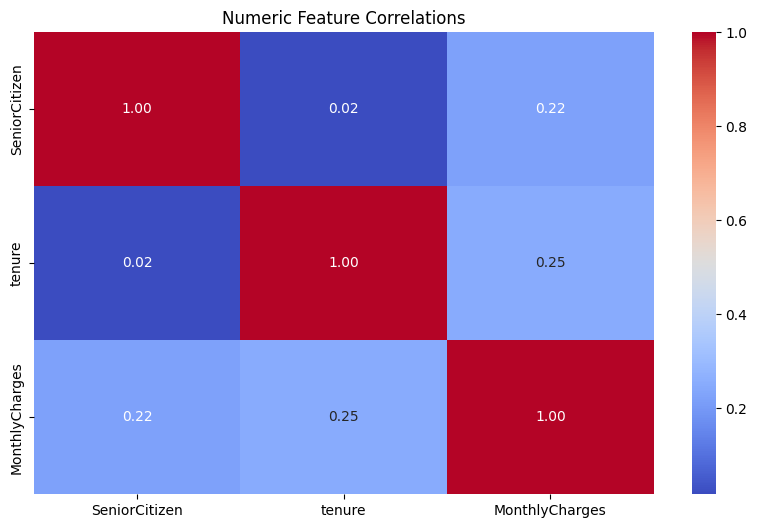

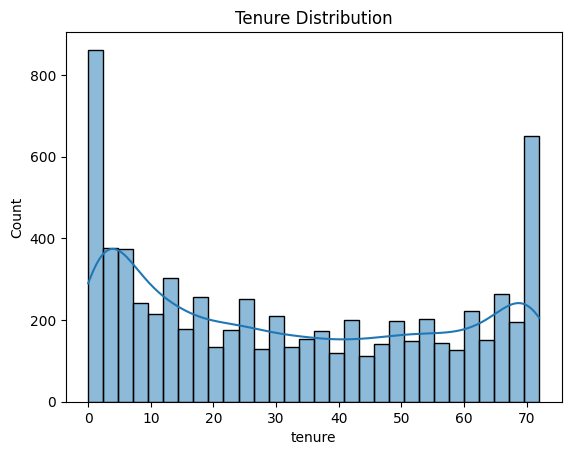

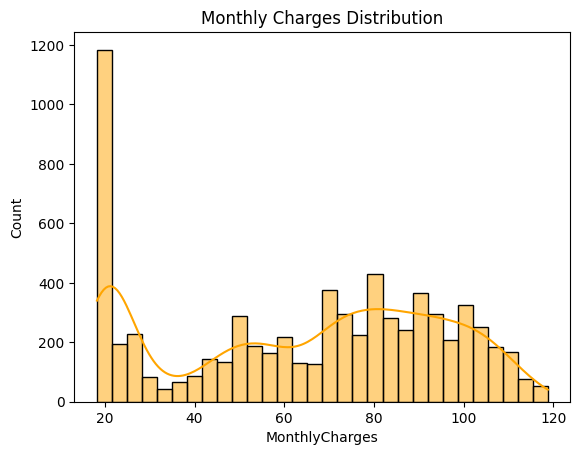

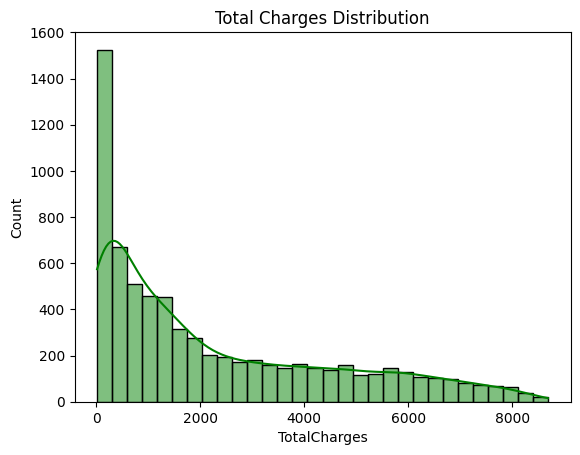

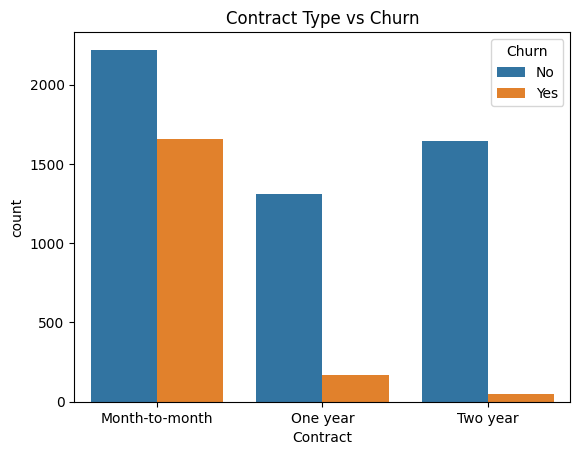

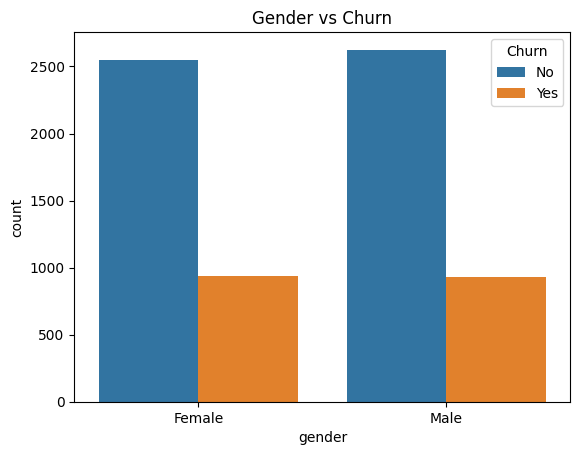

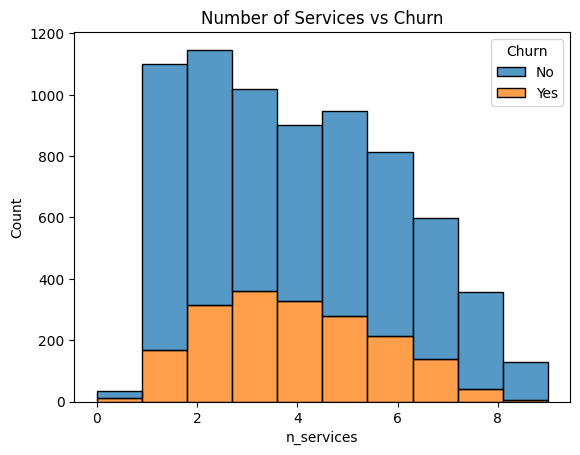

In [4]:
# Correlation heatmap for numeric features
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Numeric Feature Correlations")
plt.show()

# Distribution of tenure
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title("Tenure Distribution")
plt.show()

# Distribution of MonthlyCharges and TotalCharges
sns.histplot(df['MonthlyCharges'], bins=30, kde=True, color='orange')
plt.title("Monthly Charges Distribution")
plt.show()
sns.histplot(pd.to_numeric(df['TotalCharges'], errors='coerce'), bins=30, kde=True, color='green')
plt.title("Total Charges Distribution")
plt.show()

# Categorical feature counts (example: Contract type)
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Contract Type vs Churn")
plt.show()

# Gender vs Churn
sns.countplot(data=df, x='gender', hue='Churn')
plt.title("Gender vs Churn")
plt.show()

# Number of services vs Churn (create basic n_services column)
service_cols = ['PhoneService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies','PaperlessBilling']
for c in service_cols:
    df[c] = df[c].map({'Yes':1, 'No':0, 'No internet service':0, 'No phone service':0})
df['n_services'] = df[service_cols].sum(axis=1)
sns.histplot(data=df, x='n_services', hue='Churn', multiple='stack', bins=10)
plt.title("Number of Services vs Churn")
plt.show()

In [5]:
# Normalize target to 0/1
df[TARGET] = df[TARGET].map({'Yes':1,'No':0,'Y':1,'N':0}).astype(int)

# Drop IDs
for id_col in ['customerID', 'customerId', 'id', 'ID']:
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

# TotalCharges numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan), errors='coerce')

# Tenure bins
if 'tenure' in df.columns:
    bins = [0, 6, 12, 24, 48, 60, 999]
    labels = ['0-6','7-12','13-24','25-48','49-60','61+']
    df['tenure_bin'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

# Map Yes/No columns to 0/1
bool_map = {'Yes':1,'No':0,'yes':1,'no':0,'No internet service':0,'No phone service':0}
for c in df.select_dtypes(include='object').columns:
    if df[c].isin(bool_map.keys()).mean() > 0.5:
        df[c] = df[c].map(bool_map).fillna(0)

# Interaction features
if 'MonthlyCharges' in df.columns and 'tenure' in df.columns:
    df['charges_times_tenure'] = df['MonthlyCharges'] * df['tenure']
if 'TotalCharges' in df.columns and 'MonthlyCharges' in df.columns:
    df['avg_charge_check'] = df['TotalCharges'] / (df['MonthlyCharges'] + 1e-5)

# Number of services
service_cols = ['PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling']
svc_bin_cols = [c for c in service_cols if c in df.columns]
if svc_bin_cols:
    df['n_services'] = df[svc_bin_cols].sum(axis=1)

# Fill missing
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].fillna('Missing')

# View newly engineered features
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,n_services,tenure_bin,charges_times_tenure,avg_charge_check
0,Female,0,1,0,1,0,0,DSL,0,1,...,Month-to-month,1,Electronic check,29.85,29.85,0,2,0-6,29.85,1.000000
1,Male,0,0,0,34,1,0,DSL,1,0,...,One year,0,Mailed check,56.95,1889.50,0,3,25-48,1936.30,33.178221
2,Male,0,0,0,2,1,0,DSL,1,1,...,Month-to-month,1,Mailed check,53.85,108.15,1,4,0-6,107.70,2.008356
3,Male,0,0,0,45,0,0,DSL,1,0,...,One year,0,Bank transfer (automatic),42.30,1840.75,0,3,25-48,1903.50,43.516538
4,Female,0,0,0,2,1,0,Fiber optic,0,0,...,Month-to-month,1,Electronic check,70.70,151.65,1,2,0-6,141.40,2.144978


In [6]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [7]:
best_params = {
    "RF": {"n_estimators":300, "max_depth":12, "min_samples_leaf":3, "random_state":RANDOM_STATE},
    "GB": {"n_estimators":200, "learning_rate":0.1, "max_depth":3, "random_state":RANDOM_STATE},
    "LR": {"C":1, "penalty":"l2", "solver":"liblinear", "random_state":RANDOM_STATE}
}

models = {"RF": RandomForestClassifier, "GB": GradientBoostingClassifier, "LR": LogisticRegression}

samplers = {"SMOTE": SMOTE(random_state=RANDOM_STATE),
            "SMOTEENN": SMOTEENN(random_state=RANDOM_STATE),
            "SMOTETomek": SMOTETomek(random_state=RANDOM_STATE)}


In [8]:
# ============ FUNCTION ============
def run_experiment(model_name, sampler_name, resampler):
    exp_name = f"{model_name}_{sampler_name}"
    model_path = os.path.join(SAVE_DIR, f"{exp_name}_pipeline.pkl")
    meta_path = os.path.join(SAVE_DIR, f"{exp_name}_meta.json")

    if os.path.exists(model_path) and os.path.exists(meta_path):
        print(f"🔄 Loading saved model: {exp_name}")
        best_pipe = joblib.load(model_path)
        with open(meta_path,"r") as f: meta = json.load(f)
    else:
        print(f"🚀 Training: {exp_name}")
        tuned_clf = models[model_name](**best_params[model_name])
        pipe = ImbPipeline([("preproc", preprocessor), ("resample", resampler), ("clf", tuned_clf)])
        pipe.fit(X_train, y_train)
        joblib.dump(pipe, model_path)

        y_train_prob = cross_val_predict(pipe, X_train, y_train, cv=3, method="predict_proba")[:,1]
        prec, rec, thresh = precision_recall_curve(y_train, y_train_prob)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_idx = np.argmax(f1s)
        best_thresh = float(thresh[best_idx]) if best_idx < len(thresh) else 0.5

        meta = {
            "best_params": best_params[model_name],
            "best_threshold": best_thresh
        }
        with open(meta_path,"w") as f: json.dump(meta,f)
        best_pipe = pipe

    y_test_prob = best_pipe.predict_proba(X_test)[:,1]
    y_test_pred = (y_test_prob >= meta["best_threshold"]).astype(int)

    # 10-fold CV Accuracy
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv_acc = cross_val_score(best_pipe, X, y, cv=cv, scoring="accuracy", n_jobs=N_JOBS)
    cv_f1 = cross_val_score(best_pipe, X, y, cv=cv, scoring="f1", n_jobs=N_JOBS)

    res = {
        "model": model_name,
        "sampler": sampler_name,
        "roc_auc": roc_auc_score(y_test, y_test_prob),
        "f1": f1_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "accuracy": accuracy_score(y_test, y_test_pred),
        "cv_accuracy_mean": cv_acc.mean(),
        "cv_accuracy_std": cv_acc.std(),
        "cv_f1_mean": cv_f1.mean(),
        "cv_f1_std": cv_f1.std(),
        "mcc": matthews_corrcoef(y_test, y_test_pred),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "probs": y_test_prob
    }
    return res

In [9]:
all_results = []
for mname in models.keys():
    for sname,sampler in samplers.items():
        res = run_experiment(mname, sname, sampler)
        all_results.append(res)

summary_df = pd.DataFrame(all_results)
summary_df.to_csv(os.path.join(SAVE_DIR,"summary_results.csv"), index=False)
print(summary_df)


🚀 Training: RF_SMOTE
🚀 Training: RF_SMOTEENN
🚀 Training: RF_SMOTETomek
🚀 Training: GB_SMOTE
🚀 Training: GB_SMOTEENN
🚀 Training: GB_SMOTETomek
🚀 Training: LR_SMOTE
🚀 Training: LR_SMOTEENN
🚀 Training: LR_SMOTETomek
  model     sampler   roc_auc        f1  precision    recall  accuracy  \
0    RF       SMOTE  0.839384  0.628763   0.539197  0.754011  0.763662   
1    RF    SMOTEENN  0.841406  0.621532   0.531309  0.748663  0.757984   
2    RF  SMOTETomek  0.840277  0.622120   0.546559  0.721925  0.767211   
3    GB       SMOTE  0.840963  0.621532   0.531309  0.748663  0.757984   
4    GB    SMOTEENN  0.842335  0.619202   0.518987  0.767380  0.749468   
5    GB  SMOTETomek  0.839391  0.620455   0.539526  0.729947  0.762952   
6    LR       SMOTE  0.843853  0.623773   0.526703  0.764706  0.755145   
7    LR    SMOTEENN  0.843375  0.622322   0.538012  0.737968  0.762243   
8    LR  SMOTETomek  0.843220  0.620614   0.526022  0.756684  0.754436   

   cv_accuracy_mean  cv_accuracy_std  cv_f1_me

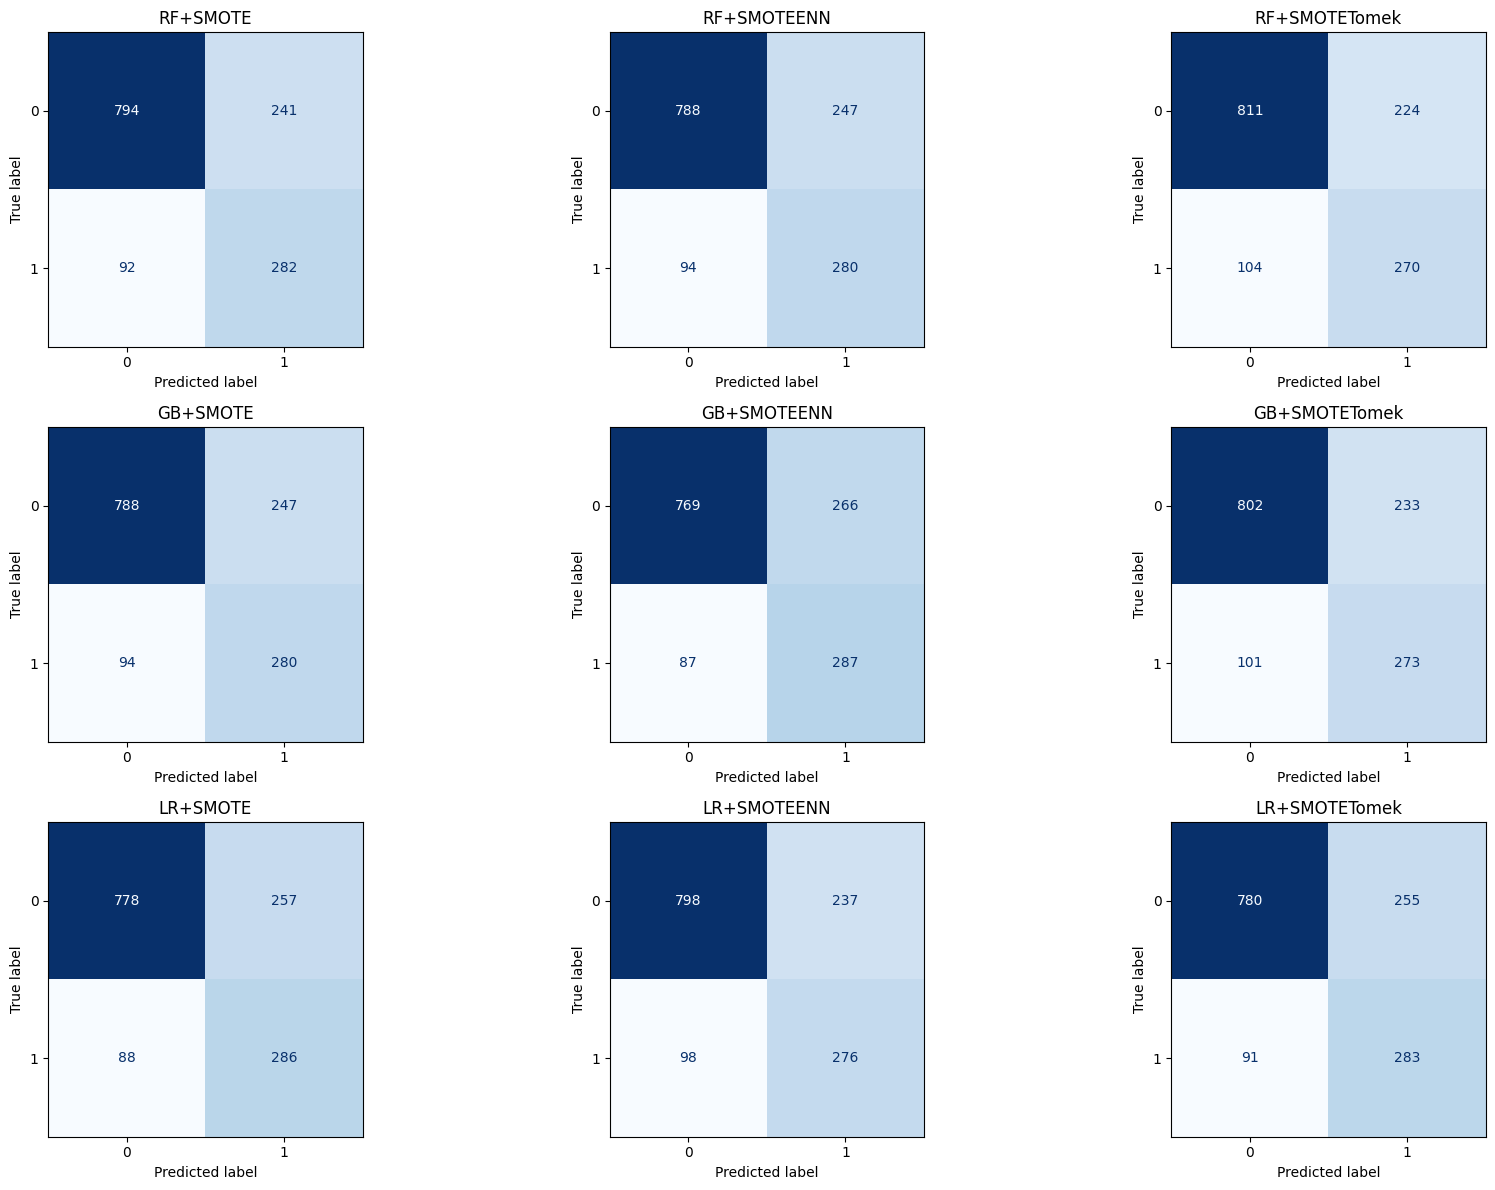

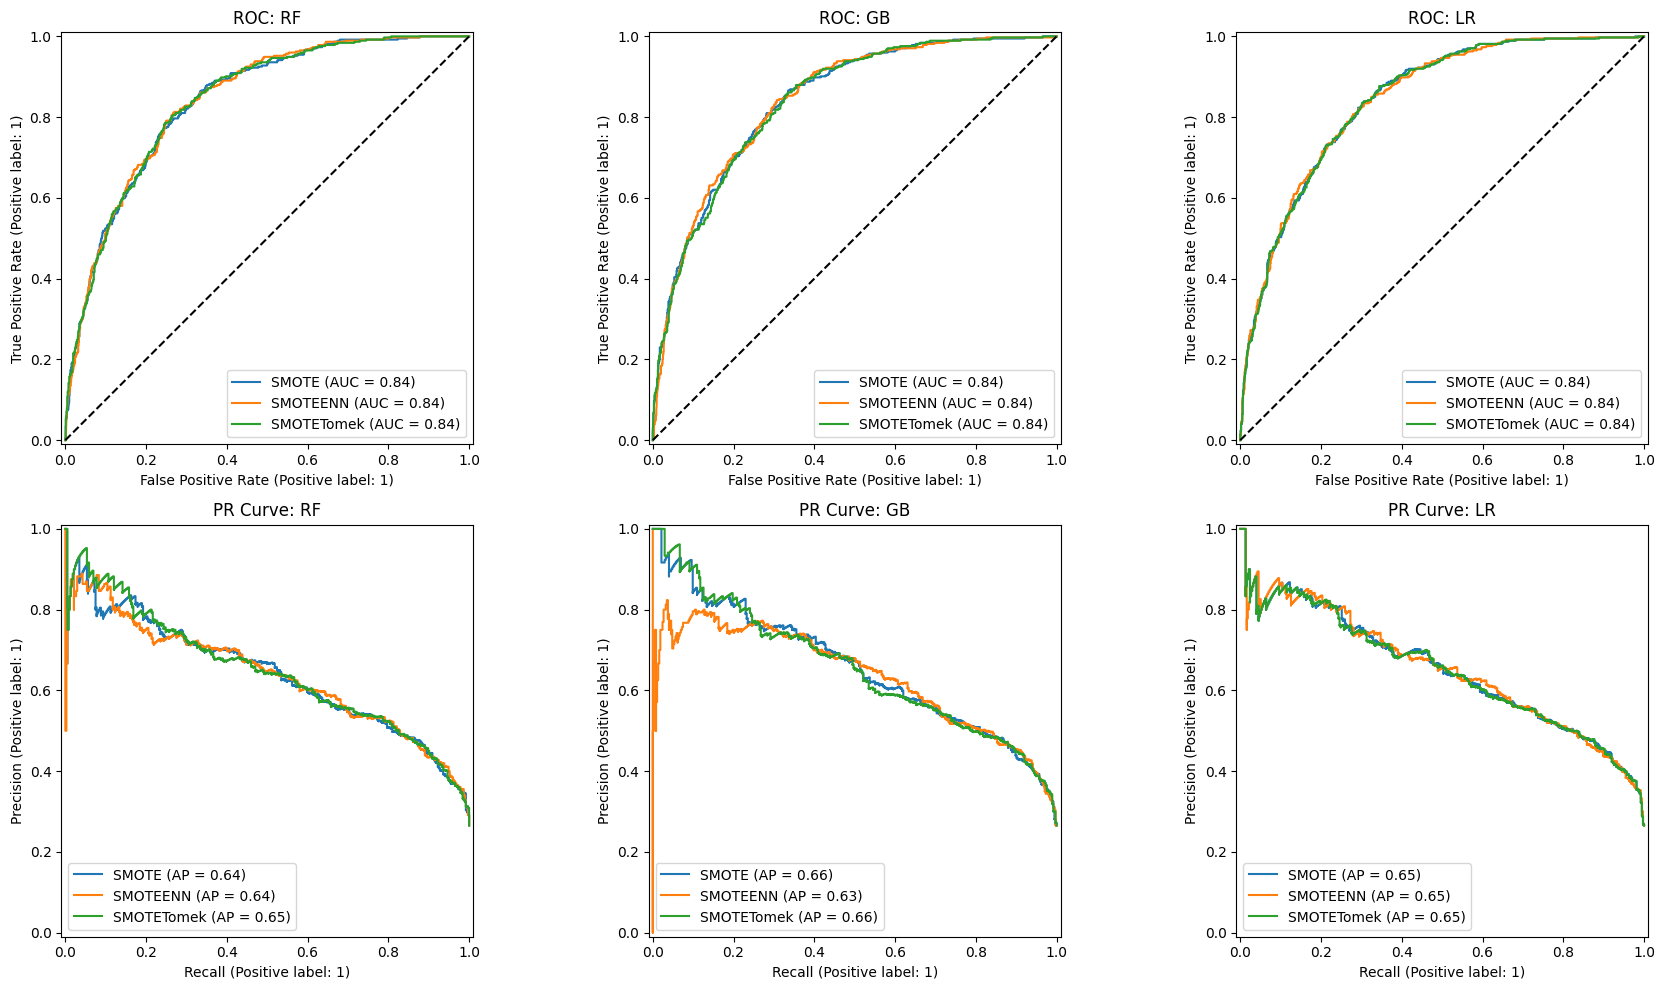

In [10]:
# ============ PLOTS ============
# Confusion matrices
fig, axes = plt.subplots(len(models), len(samplers), figsize=(18,12))
for i,mname in enumerate(models.keys()):
    for j,sname in enumerate(samplers.keys()):
        ax = axes[i,j]
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        ConfusionMatrixDisplay(r["confusion_matrix"]).plot(ax=ax, cmap="Blues", colorbar=False)
        ax.set_title(f"{mname}+{sname}")
plt.tight_layout()
plt.show()

# ROC and PR curves in subplots
fig, axes = plt.subplots(2,len(models), figsize=(18,10))

for i,mname in enumerate(models.keys()):
    # ROC
    ax = axes[0,i]
    for sname in samplers.keys():
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        RocCurveDisplay.from_predictions(y_test, r["probs"], name=sname, ax=ax)
    ax.plot([0,1],[0,1],"k--")
    ax.set_title(f"ROC: {mname}")

    # Precision-Recall
    ax = axes[1,i]
    for sname in samplers.keys():
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        PrecisionRecallDisplay.from_predictions(y_test, r["probs"], name=sname, ax=ax)
    ax.set_title(f"PR Curve: {mname}")

plt.tight_layout()
plt.show()


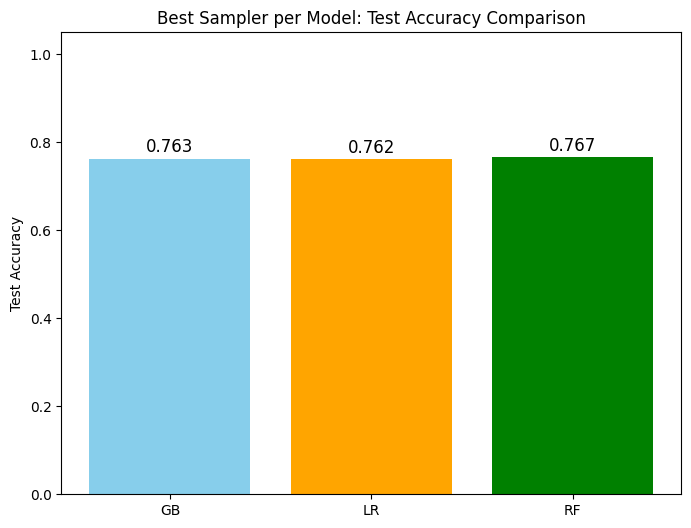

  model     sampler  accuracy  cv_accuracy_mean  cv_accuracy_std
5    GB  SMOTETomek  0.762952          0.791421         0.022022
7    LR    SMOTEENN  0.762243          0.704952         0.024780
2    RF  SMOTETomek  0.767211          0.783043         0.016464


In [11]:
best_results = summary_df.loc[summary_df.groupby('model')['accuracy'].idxmax()]
plt.figure(figsize=(8,6))
plt.bar(best_results['model'], best_results['accuracy'], color=['skyblue','orange','green'])
for i, acc in enumerate(best_results['accuracy']):
    plt.text(i, acc+0.005, f"{acc:.3f}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1.05)
plt.ylabel("Test Accuracy")
plt.title("Best Sampler per Model: Test Accuracy Comparison")
plt.show()

print(best_results[['model','sampler','accuracy','cv_accuracy_mean','cv_accuracy_std']])



===== Best sampler for RF =====
Sampler: SMOTE
Classification Report:


array([[794, 241],
       [ 92, 282]])


===== Best sampler for GB =====
Sampler: SMOTE
Classification Report:


array([[788, 247],
       [ 94, 280]])


===== Best sampler for LR =====
Sampler: SMOTE
Classification Report:


array([[778, 257],
       [ 88, 286]])

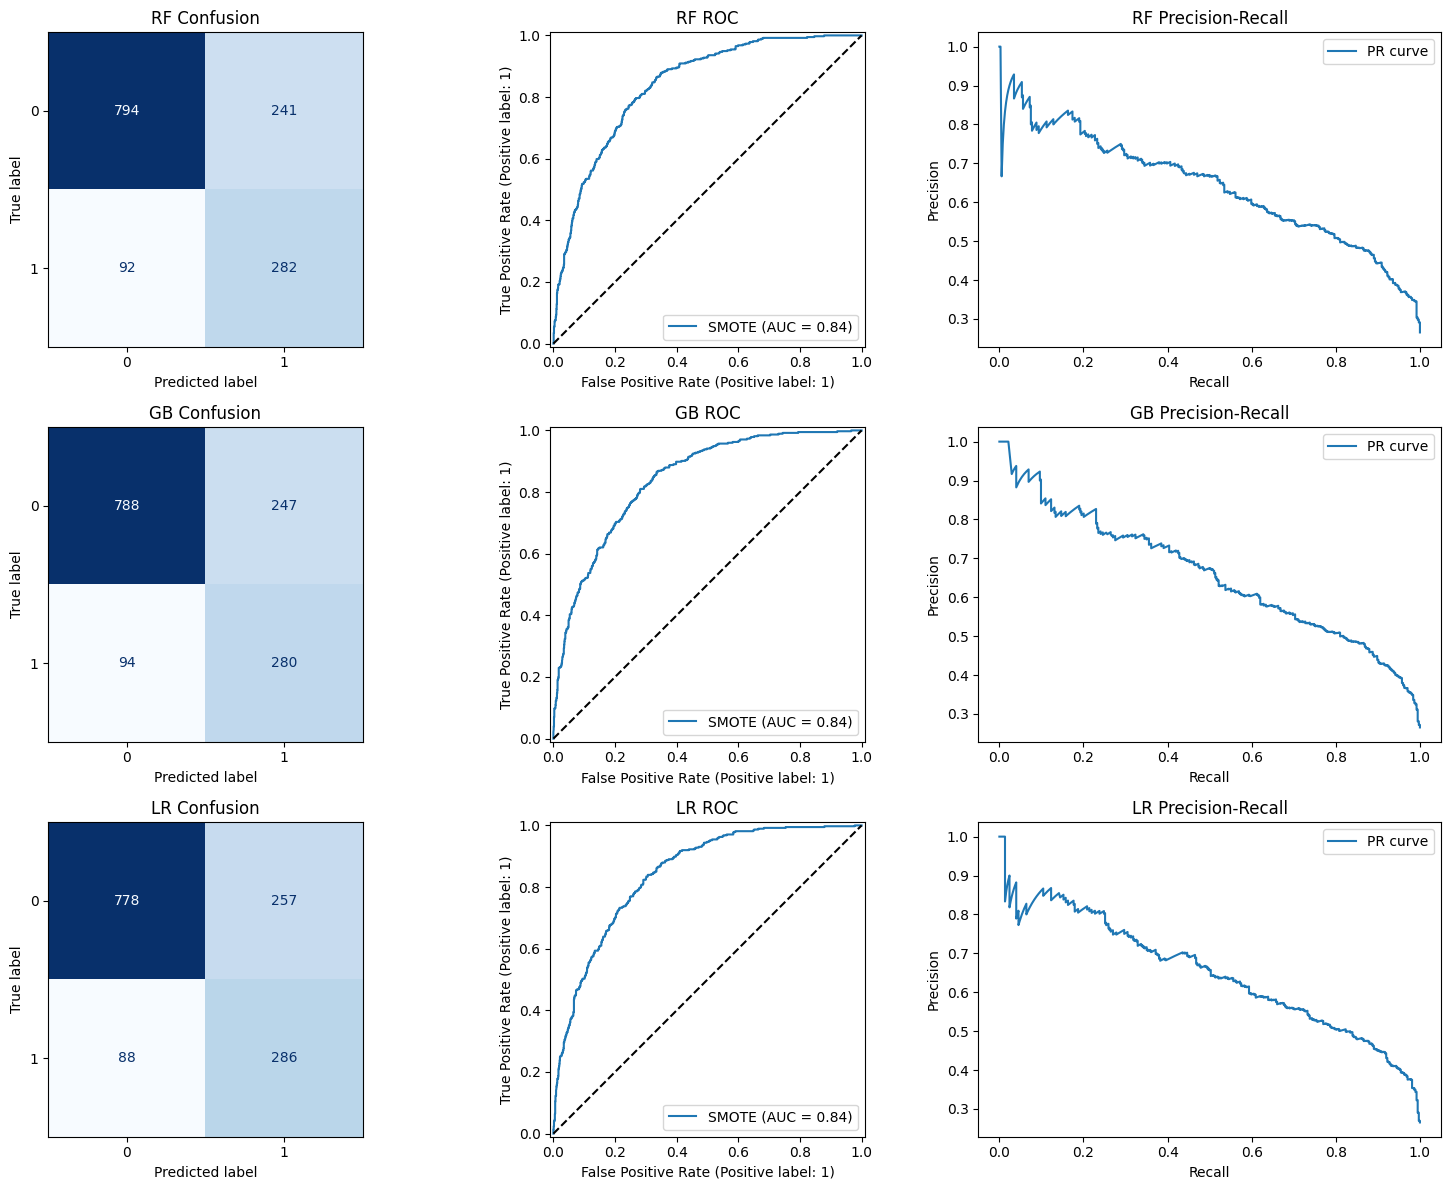

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve

best_results = {}
for model_name in ["RF", "GB", "LR"]:
    # Select row with highest F1
    subset = summary_df[summary_df["model"]==model_name]
    best_row = subset.loc[subset["f1"].idxmax()]
    best_results[model_name] = best_row

    # Print classification report
    print(f"\n===== Best sampler for {model_name} =====")
    print("Sampler:", best_row["sampler"])
    print("Classification Report:")
    display(best_row["confusion_matrix"])
    y_test_pred = best_row["confusion_matrix"]

# ============ Plot Confusion Matrix, ROC, PR ============

fig, axes = plt.subplots(3,3, figsize=(15,12))
for i, model_name in enumerate(["RF","GB","LR"]):
    best_row = best_results[model_name]
    sampler_name = best_row["sampler"]

    # Load pipeline
    pipeline_path = f"{SAVE_DIR}/{model_name}_{sampler_name}_pipeline.pkl"
    pipe = joblib.load(pipeline_path)

    # Threshold tuning
    y_test_prob = pipe.predict_proba(X_test)[:,1]
    meta_path = f"{SAVE_DIR}/{model_name}_{sampler_name}_meta.json"
    with open(meta_path,"r") as f:
        meta = json.load(f)
    best_threshold = meta.get("best_threshold",0.5)
    y_test_pred = (y_test_prob >= best_threshold).astype(int)

    # Confusion matrix
    ax = axes[i,0]
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{model_name} Confusion")

    # ROC
    ax = axes[i,1]
    RocCurveDisplay.from_predictions(y_test, y_test_prob, name=sampler_name, ax=ax)
    ax.plot([0,1],[0,1],"k--")
    ax.set_title(f"{model_name} ROC")

    # Precision-Recall
    ax = axes[i,2]
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    ax.plot(recall, precision, label="PR curve")
    ax.set_title(f"{model_name} Precision-Recall")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()

plt.tight_layout()
plt.show()

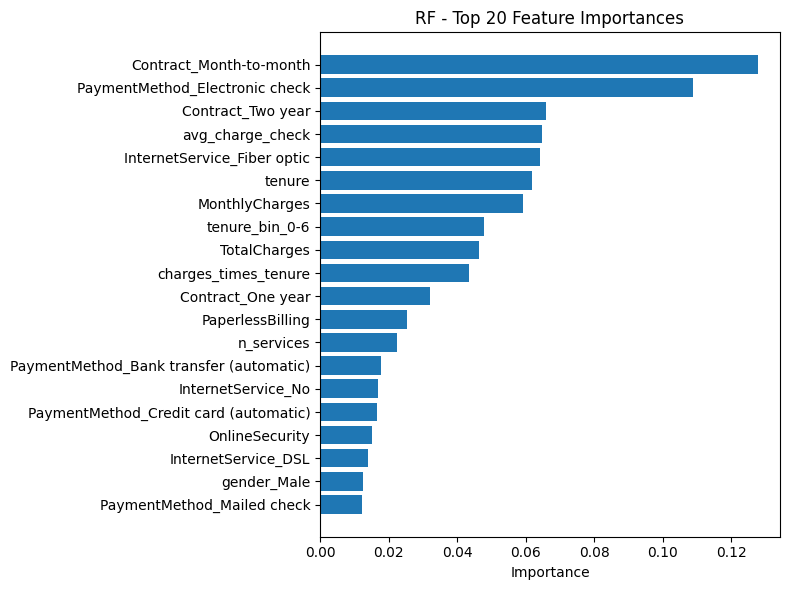

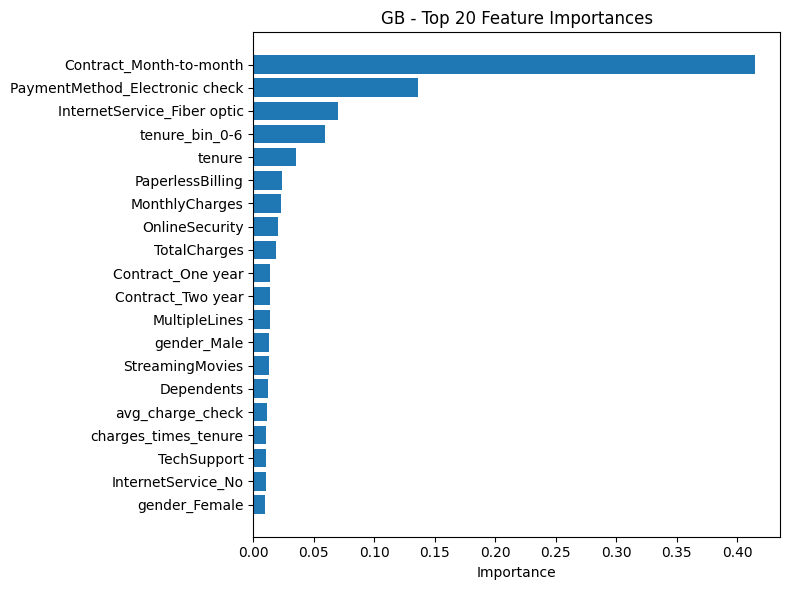

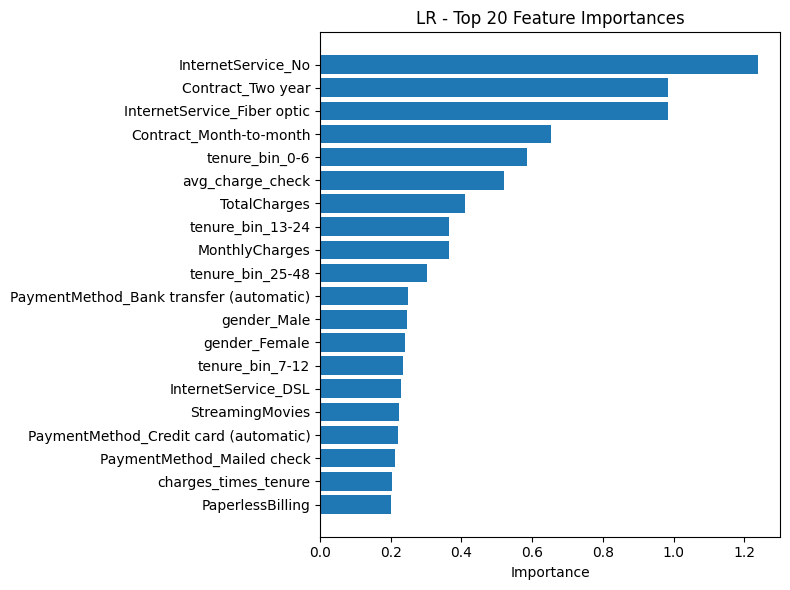

In [13]:
# Helper to extract feature names after preprocessing
def get_feature_names(preprocessor, input_features):
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)
    return feature_names

for model_name in ["RF", "GB", "LR"]:
    best_row = best_results[model_name]
    sampler_name = best_row["sampler"]
    pipe = joblib.load(f"{SAVE_DIR}/{model_name}_{sampler_name}_pipeline.pkl")

    # Get full feature names after preprocessing
    feature_names = get_feature_names(pipe.named_steps['preproc'], X.columns)

    # Get importances or coefficients
    if model_name == "LR":
        importances = np.abs(pipe.named_steps['clf'].coef_[0])
    else:
        importances = pipe.named_steps['clf'].feature_importances_

    # Top 20 indices
    indices = np.argsort(importances)[-20:]

    # Plot
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_names)[indices], importances[indices])
    plt.title(f"{model_name} - Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


In [14]:
import pandas as pd
import numpy as np
import os, joblib, json
from sklearn.model_selection import train_test_split


DATA_PATH = "/content/IBM Telco Dataset (7043).csv"
TARGET = "Churn"

df = pd.read_csv(DATA_PATH)
df = df.rename(columns=lambda c: c.strip())

# Normalize target to 0/1
df[TARGET] = df[TARGET].map({'Yes':1,'No':0,'Y':1,'N':0}).astype(int)

# Drop IDs
for id_col in ['customerID', 'customerId', 'id', 'ID']:
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

# TotalCharges numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan), errors='coerce')

# Tenure bins
if 'tenure' in df.columns:
    bins = [0, 6, 12, 24, 48, 60, 999]
    labels = ['0-6','7-12','13-24','25-48','49-60','61+']
    df['tenure_bin'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

# Map Yes/No columns to 0/1
bool_map = {'Yes':1,'No':0,'yes':1,'no':0,'No internet service':0,'No phone service':0}
for c in df.select_dtypes(include='object').columns:
    if df[c].isin(bool_map.keys()).mean() > 0.5:
        df[c] = df[c].map(bool_map).fillna(0)

# Interaction features
if 'MonthlyCharges' in df.columns and 'tenure' in df.columns:
    df['charges_times_tenure'] = df['MonthlyCharges'] * df['tenure']
if 'TotalCharges' in df.columns and 'MonthlyCharges' in df.columns:
    df['avg_charge_check'] = df['TotalCharges'] / (df['MonthlyCharges'] + 1e-5)

# Number of services
service_cols = ['PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling']
svc_bin_cols = [c for c in service_cols if c in df.columns]
if svc_bin_cols:
    df['n_services'] = df[svc_bin_cols].sum(axis=1)

# Fill missing
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].fillna('Missing')

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train-test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

print("✅ Data loaded and feature-engineered.")

SAVE_DIR = "./artifacts_7043"
models = ["RF","GB","LR"]
pipelines, metas = {}, {}

for m in models:
    pipeline_path = os.path.join(SAVE_DIR, f"{m}_SMOTETomek_pipeline.pkl")
    meta_path = os.path.join(SAVE_DIR, f"{m}_SMOTETomek_meta.json")

    pipelines[m] = joblib.load(pipeline_path)
    with open(meta_path,"r") as f:
        metas[m] = json.load(f)
    print(f"✅ Loaded {m}_SMOTETomek pipeline with threshold {metas[m].get('best_threshold',0.5)}")



✅ Data loaded and feature-engineered.
✅ Loaded RF_SMOTETomek pipeline with threshold 0.4466062251612013
✅ Loaded GB_SMOTETomek pipeline with threshold 0.3680396581546974
✅ Loaded LR_SMOTETomek pipeline with threshold 0.5561422787743088


,Model,Threshold,Targeted,Retained,Missed,Benefit($),Cost($),Net Profit($),ROI(%),Profit per Customer($)
0,RF,0.446606,2411,1573,296,157300,24110,133190,552.426379,18.910975
1,GB,0.368040,2485,1462,407,146200,24850,121350,488.329980,17.229874
2,LR,0.556142,2603,1422,447,142200,26030,116170,446.292739,16.494392


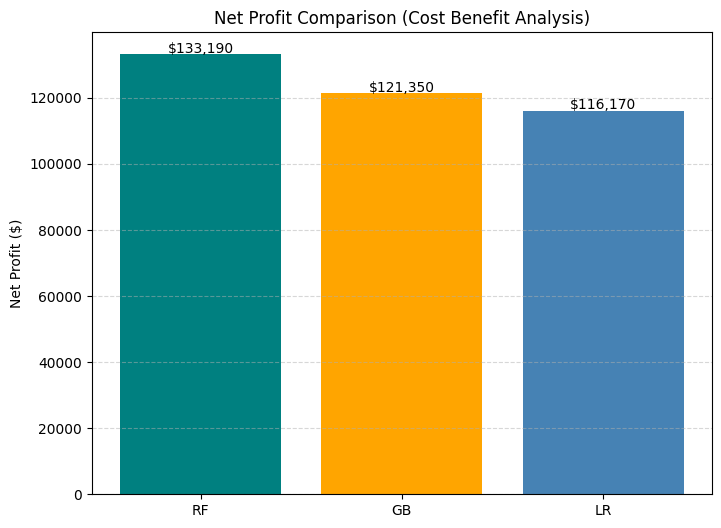

🏆 Best Model for Business: RF


In [15]:
# ============ BUSINESS-FRIENDLY COST BENEFIT ANALYSIS + SUMMARY ============
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

profit_per_retained = 100
cost_per_contact = 10

cba_records = []

for m in models:
    pipe = pipelines[m]
    meta = metas[m]
    threshold = meta.get("best_threshold",0.5)

    y_prob = pipe.predict_proba(X)[:,1]
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    targeted = tp + fp
    retained = tp
    missed = fn
    benefit = retained*profit_per_retained
    cost = targeted*cost_per_contact
    net_profit = benefit - cost
    roi = (net_profit / cost)*100 if cost>0 else 0
    profit_per_customer = net_profit / len(y)

    cba_records.append({
        "Model": m,
        "Threshold": threshold,
        "Targeted": targeted,
        "Retained": retained,
        "Missed": missed,
        "Benefit($)": benefit,
        "Cost($)": cost,
        "Net Profit($)": net_profit,
        "ROI(%)": roi,
        "Profit per Customer($)": profit_per_customer
    })

cba_df = pd.DataFrame(cba_records)
cba_df = cba_df.sort_values("Net Profit($)", ascending=False)
display(cba_df)

# Plot Net Profit
plt.figure(figsize=(8,6))
bars = plt.bar(cba_df["Model"], cba_df["Net Profit($)"], color=["teal","orange","steelblue"])
plt.title("Net Profit Comparison (Cost Benefit Analysis)")
plt.ylabel("Net Profit ($)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar,val in zip(bars,cba_df["Net Profit($)"]):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+500,f"${val:,.0f}",ha='center')
plt.show()

print(f"🏆 Best Model for Business: {cba_df.iloc[0]['Model']}")

In [16]:
# =========================
# 💼 Business-Friendly Churn Prediction Project
# =========================

PROFIT_PER_RETAINED = 100
COST_PER_CONTACT = 10
BEST_MODEL = "RF"
BEST_SAMPLER = "SMOTETomek"
BEST_THRESHOLD = 0.445

RANDOM_STATE = 42

# -------------------------
# Load trained pipeline
# -------------------------
pipeline_path = os.path.join(SAVE_DIR, f"{BEST_MODEL}_{BEST_SAMPLER}_pipeline.pkl")
meta_path = os.path.join(SAVE_DIR, f"{BEST_MODEL}_{BEST_SAMPLER}_meta.json")

pipe = joblib.load(pipeline_path)
with open(meta_path, "r") as f:
    meta = json.load(f)
best_threshold = meta.get("best_threshold", BEST_THRESHOLD)

print(f"✅ Loaded pipeline: {BEST_MODEL} + {BEST_SAMPLER} | Threshold={best_threshold}")

# -------------------------
# Bulk Test Set Predictions + CBA
# -------------------------
y_prob = pipe.predict_proba(X)[:,1]
y_pred = (y_prob >= best_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
targeted = tp + fp
retained = tp
missed = fn
benefit = retained * PROFIT_PER_RETAINED
cost = targeted * COST_PER_CONTACT
net_profit = benefit - cost
roi = (net_profit / cost) * 100 if cost>0 else 0
profit_per_customer = net_profit / len(y)

print("\n===== 💰 COST-BENEFIT SUMMARY =====")
print(f"Targeted Customers: {targeted}")
print(f"Retained Churners: {retained}")
print(f"Missed Churners: {missed}")
print(f"Benefit: ${benefit:,}")
print(f"Cost: ${cost:,}")
print(f"Net Profit: ${net_profit:,}")
print(f"ROI: {roi:.1f}%")
print(f"Profit per Customer: ${profit_per_customer:.2f}")

# High-risk customers
high_risk_customers = pd.DataFrame(X)
high_risk_customers["churn_prob"] = y_prob
high_risk_customers["action_needed"] = y_pred
high_risk_customers = high_risk_customers.sort_values(by="churn_prob", ascending=False)
print("\n📌 Top 10 High-Risk Customers:")
display(high_risk_customers.head(10))


✅ Loaded pipeline: RF + SMOTETomek | Threshold=0.4466062251612013

===== 💰 COST-BENEFIT SUMMARY =====
Targeted Customers: 2411
Retained Churners: 1573
Missed Churners: 296
Benefit: $157,300
Cost: $24,110
Net Profit: $133,190
ROI: 552.4%
Profit per Customer: $18.91

📌 Top 10 High-Risk Customers:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_bin,charges_times_tenure,avg_charge_check,n_services,churn_prob,action_needed
1325,Female,1,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.25,69.25,0-6,69.25,1.0,2,0.984993,1
5782,Female,1,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.65,69.65,0-6,69.65,1.0,2,0.984957,1
1731,Female,1,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.60,69.60,0-6,69.60,1.0,2,0.984957,1
3301,Female,1,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.60,69.60,0-6,69.60,1.0,2,0.984957,1
6488,Female,0,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.50,69.50,0-6,69.50,1.0,2,0.983970,1
4081,Female,0,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.60,69.60,0-6,69.60,1.0,2,0.983934,1
6491,Female,0,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.20,69.20,0-6,69.20,1.0,2,0.983636,1
6764,Female,0,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.20,69.20,0-6,69.20,1.0,2,0.983636,1
5573,Female,1,0,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.85,69.85,0-6,69.85,1.0,2,0.982619,1
5454,Female,1,1,0,1,1,0,Fiber optic,0,0,...,1,Electronic check,69.55,69.55,0-6,69.55,1.0,2,0.982104,1


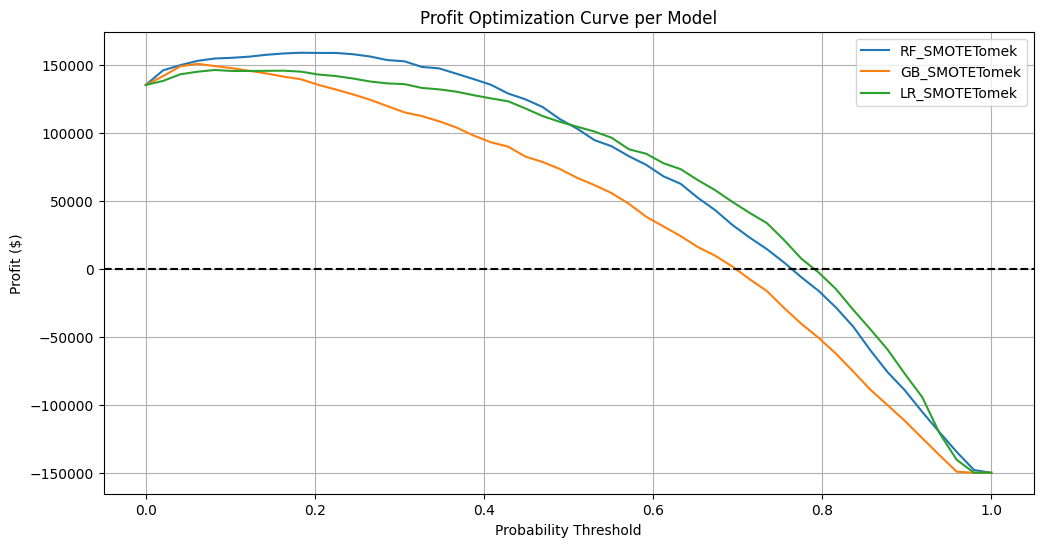

📊 Profit Optimization Summary:


,Model,Sampler,Meta_Threshold,Profit_Optimal_Threshold,Max_Profit
0,RF,SMOTETomek,0.446606,0.184,158820
1,GB,SMOTETomek,0.368040,0.061,150700
2,LR,SMOTETomek,0.556142,0.082,146160



🏆 Best Model for Profit: RF + SMOTETomek
💰 Max Profit: $158,820 at Threshold=0.184
📌 Meta Threshold used in pipeline: 0.4466062251612013


In [17]:
# ==============================
# 💹 Profit Optimization Curve
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib

# Business assumptions
profit_per_retained = 100
cost_per_contact = 10
loss_per_missed = 80

# Thresholds to evaluate
thresholds = np.linspace(0, 1, 50)

profit_summary = []

plt.figure(figsize=(12,6))

for model_name in ["RF","GB","LR"]:
    sampler_name = "SMOTETomek"

    # Load pipeline and meta
    pipe = joblib.load(f"./artifacts_7043/{model_name}_{sampler_name}_pipeline.pkl")
    meta = metas[model_name]

    # Predicted probabilities
    y_prob = pipe.predict_proba(X)[:,1]

    # Compute profits for all thresholds
    profits = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        profit = tp*profit_per_retained - fp*cost_per_contact - fn*loss_per_missed
        profits.append(profit)

    profits = np.array(profits)
    plt.plot(thresholds, profits, label=f"{model_name}_{sampler_name}")

    # Best threshold and max profit
    best_idx = np.argmax(profits)
    best_t = thresholds[best_idx]
    max_profit = profits[best_idx]

    profit_summary.append({
        "Model": model_name,
        "Sampler": sampler_name,
        "Meta_Threshold": meta.get("best_threshold",0.5),
        "Profit_Optimal_Threshold": round(best_t,3),
        "Max_Profit": round(max_profit,2)
    })

# Plot formatting
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Probability Threshold")
plt.ylabel("Profit ($)")
plt.title("Profit Optimization Curve per Model")
plt.grid(True)
plt.legend()
plt.show()

# Profit optimization summary table
profit_summary_df = pd.DataFrame(profit_summary).sort_values("Max_Profit", ascending=False)
print("📊 Profit Optimization Summary:")
display(profit_summary_df)

# Identify the best model by max profit
best_model = profit_summary_df.iloc[0]
print(f"\n🏆 Best Model for Profit: {best_model['Model']} + {best_model['Sampler']}")
print(f"💰 Max Profit: ${best_model['Max_Profit']:,} at Threshold={best_model['Profit_Optimal_Threshold']}")
print(f"📌 Meta Threshold used in pipeline: {best_model['Meta_Threshold']}")


===== SHAP Explanation for RF_SMOTETomek =====
Global SHAP - Beeswarm & Bar Plots


<Figure size 600x600 with 0 Axes>

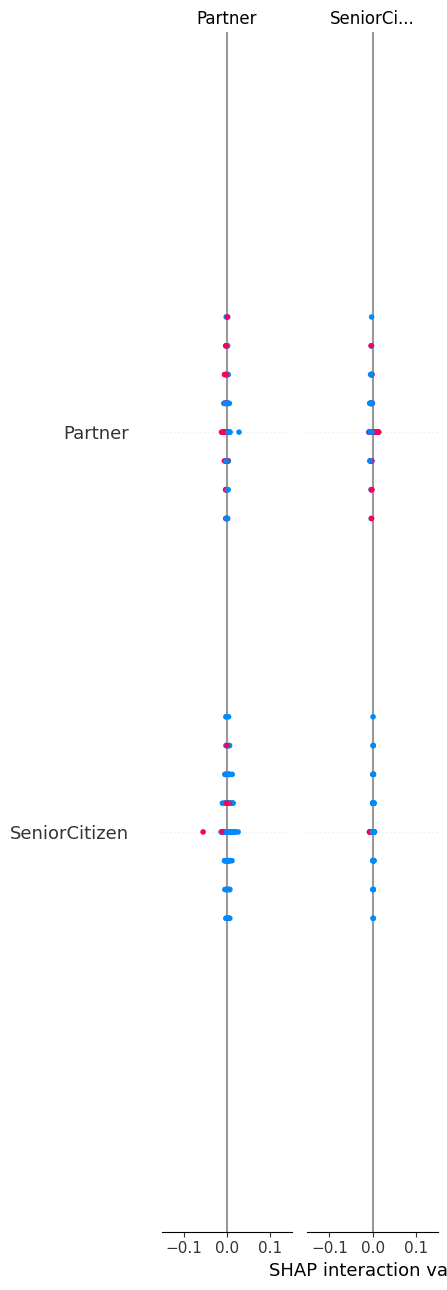

✅ Saved Beeswarm plot: shap_plots/RF_SMOTETomek_global_beeswarm.png


<Figure size 1000x600 with 0 Axes>

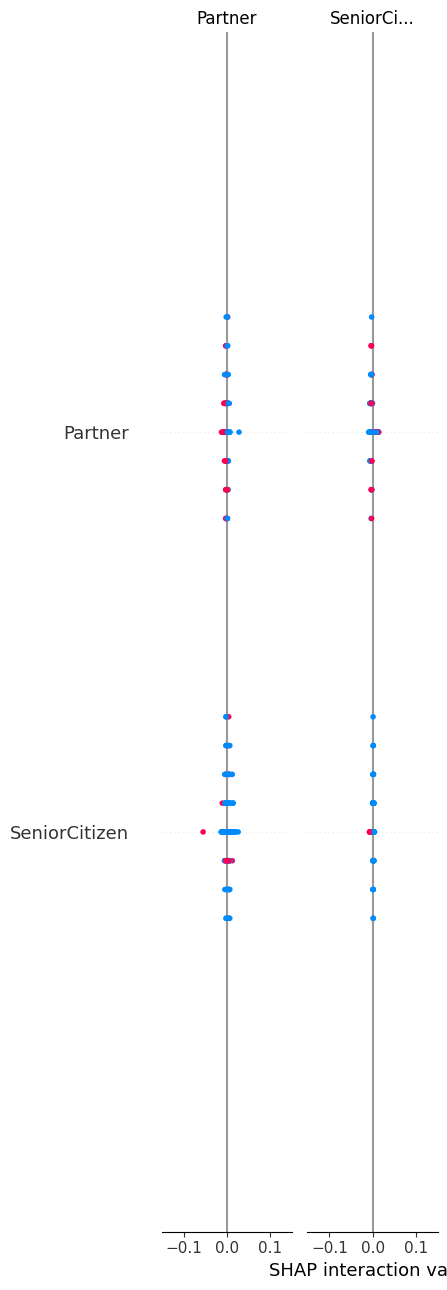

✅ Saved Bar plot: shap_plots/RF_SMOTETomek_global_bar.png
Local SHAP - Instance 0


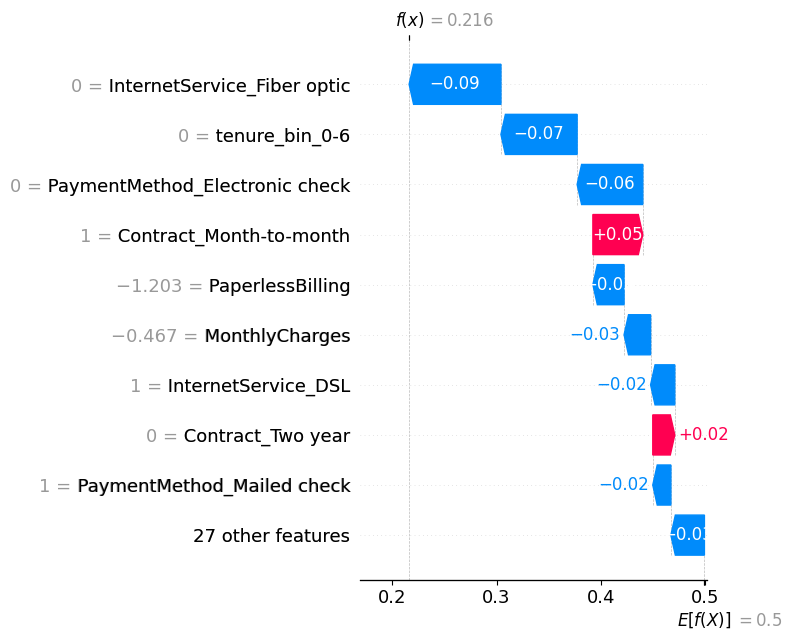

✅ Saved Waterfall plot: shap_plots/RF_SMOTETomek_local_waterfall_0.png


Force Plot (interactive):


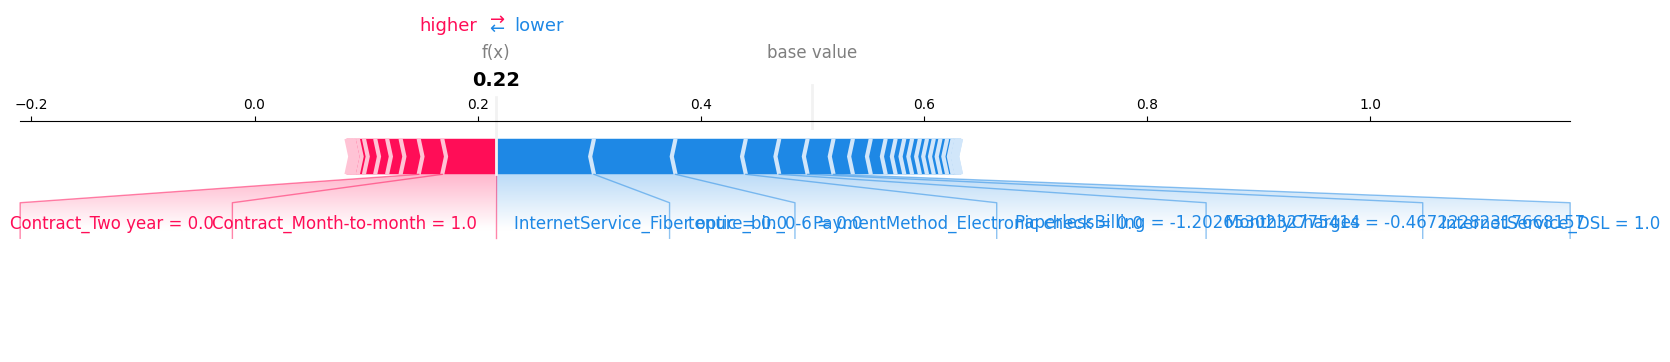

None


===== SHAP Explanation for GB_SMOTETomek =====
Global SHAP - Beeswarm & Bar Plots


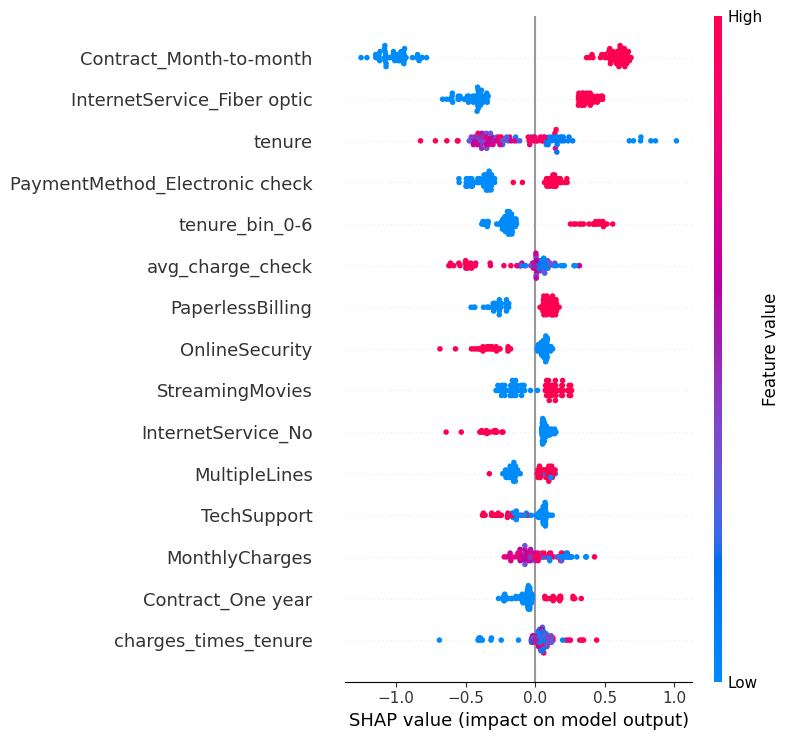

✅ Saved Beeswarm plot: shap_plots/GB_SMOTETomek_global_beeswarm.png


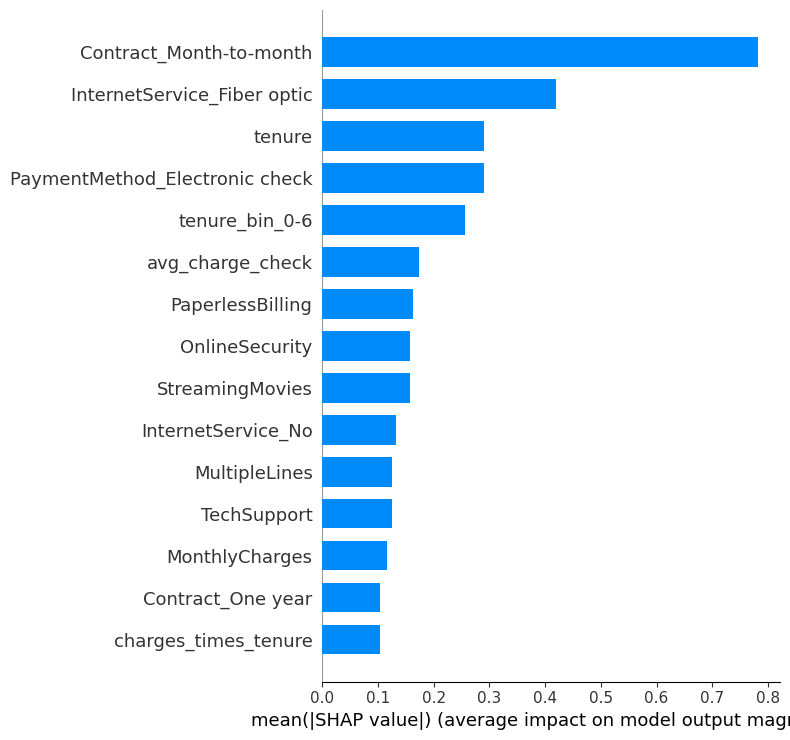

✅ Saved Bar plot: shap_plots/GB_SMOTETomek_global_bar.png
Local SHAP - Instance 0


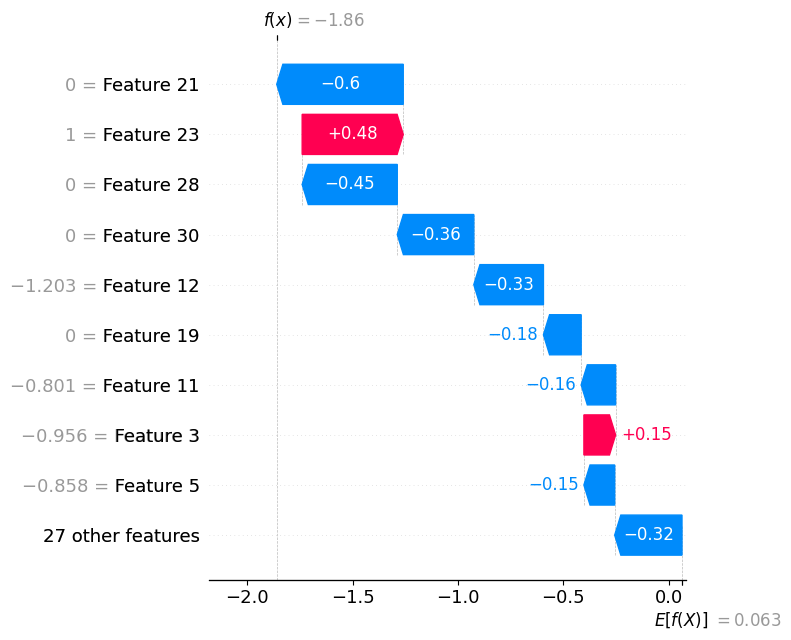

✅ Saved Waterfall plot: shap_plots/GB_SMOTETomek_local_waterfall_0.png


Force Plot (interactive):


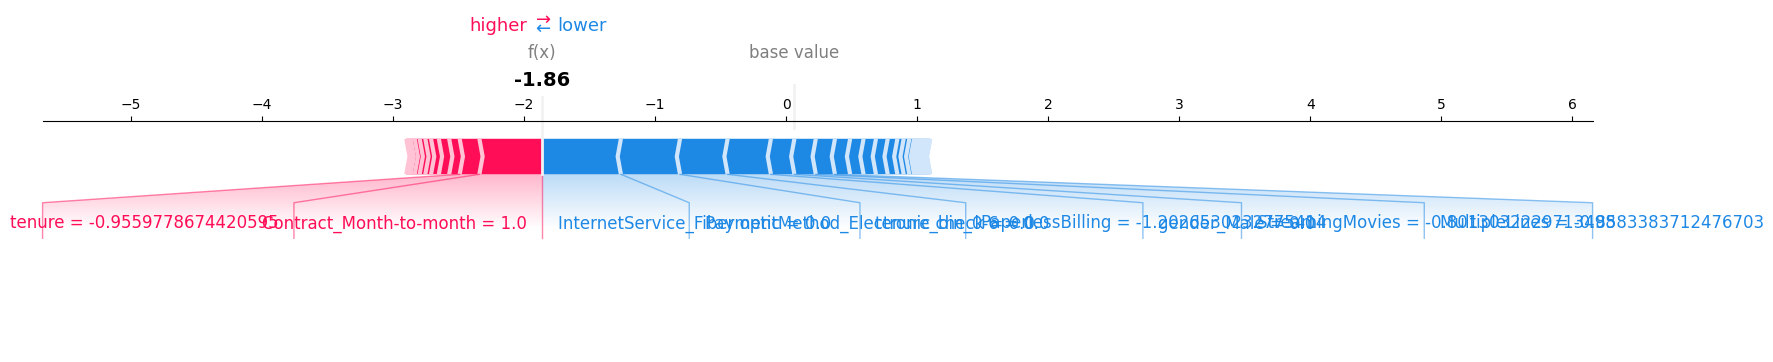

None


===== SHAP Explanation for LR_SMOTETomek =====
Global SHAP - Beeswarm & Bar Plots


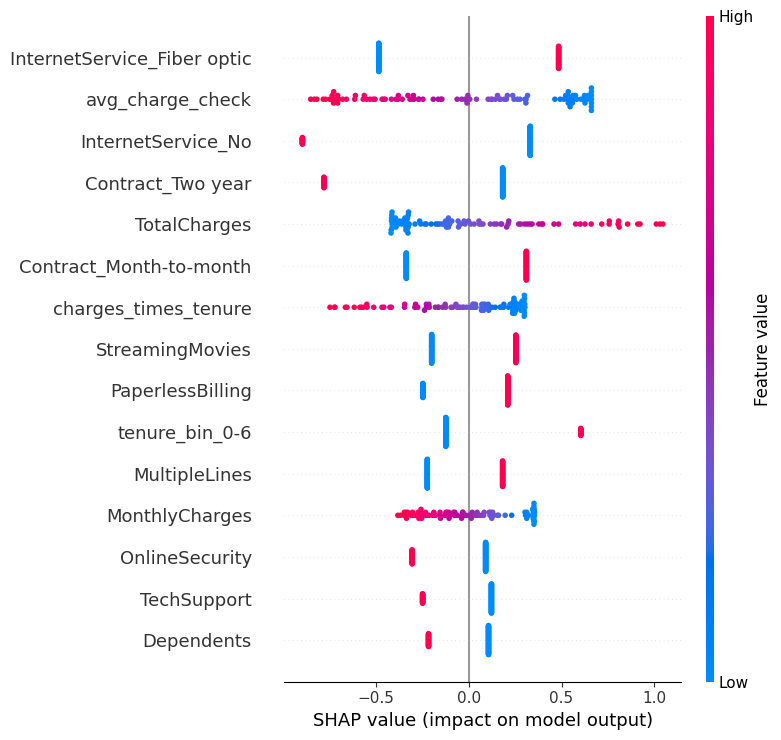

✅ Saved Beeswarm plot: shap_plots/LR_SMOTETomek_global_beeswarm.png


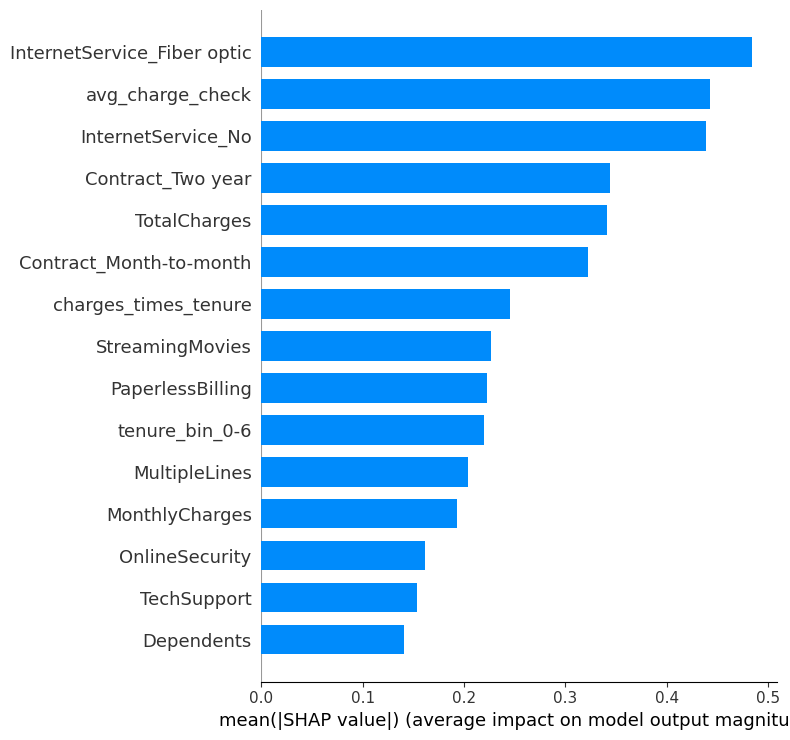

✅ Saved Bar plot: shap_plots/LR_SMOTETomek_global_bar.png
Local SHAP - Instance 0


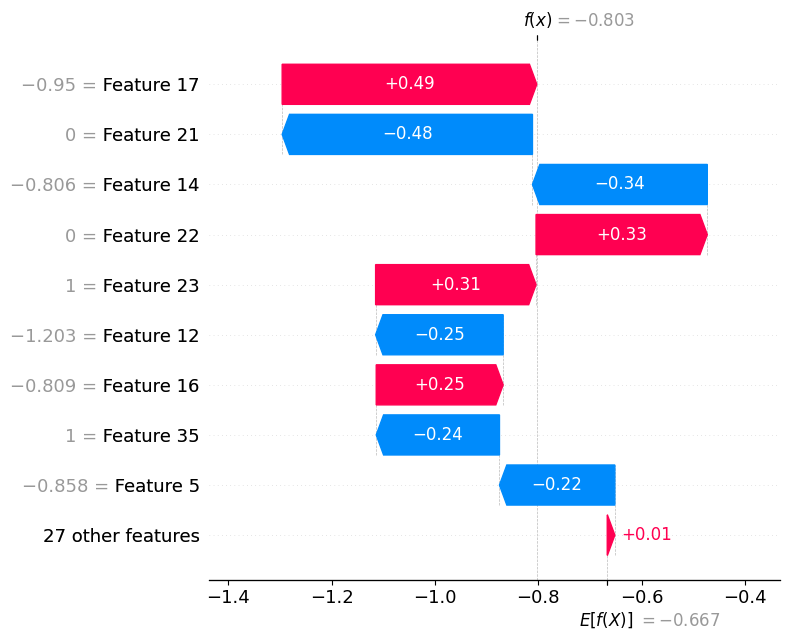

✅ Saved Waterfall plot: shap_plots/LR_SMOTETomek_local_waterfall_0.png


Force Plot (interactive):


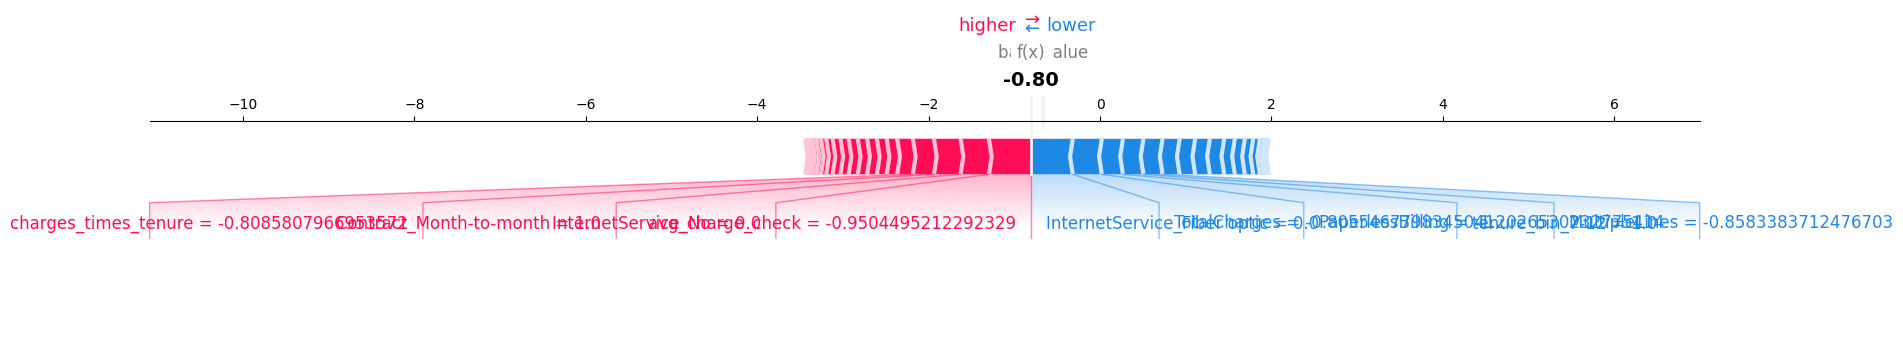

None

In [19]:
# ==============================
# ✅ SHAP EXPLAINABILITY BLOCK
# ==============================
import shap
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
modelname=["RF_SMOTETomek","RF_SMOTETomek","RF_SMOTETomek"]
def explain_with_shap(
    pipeline,
    model_name,
    X_train,
    X_test,
    num_samples=100,
    instance_idx=0,
    max_display_global=15,
    max_display_local=10,
    save_dir="shap_plots"
):
    """
    Generate SHAP explanations (global + local) for a fitted pipeline.
    """
    os.makedirs(save_dir, exist_ok=True)
    print(f"\n===== SHAP Explanation for {model_name} =====")

    # ---- Sample subset for speed ----
    X_sample = X_test.sample(min(num_samples, len(X_test)), random_state=42).reset_index(drop=True)
    if instance_idx >= len(X_sample):
        print(f"⚠️ instance_idx={instance_idx} exceeds sample size ({len(X_sample)}). Resetting to 0.")
        instance_idx = 0

    # ---- Extract model + preprocessor ----
    model = pipeline.named_steps['clf']
    preprocessor_step = pipeline.named_steps.get('preproc', None)
    if preprocessor_step is None:
        raise ValueError("❌ Preprocessor step not found in pipeline.")

    # ---- Transform data ----
    X_train_trans = preprocessor_step.transform(X_train)
    X_sample_trans = preprocessor_step.transform(X_sample)

    # ---- Get feature names after preprocessing ----
    feature_names = []
    for name, trans, cols in preprocessor_step.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)

    # ---- Create SHAP explainer ----
    model_type = str(type(model))
    if "Forest" in model_type or "Boost" in model_type:
        explainer = shap.TreeExplainer(model)
    elif "LogisticRegression" in model_type:
        explainer = shap.LinearExplainer(model, X_train_trans, feature_perturbation="interventional")
    else:
        explainer = shap.Explainer(model, X_train_trans)

    # ---- Compute SHAP values ----
    shap_values = explainer(X_sample_trans)

    # ==============================
    # 🌍 GLOBAL SHAP PLOTS
    # ==============================
    print("Global SHAP - Beeswarm & Bar Plots")

    plt.figure(figsize=(6, 6))
    shap.summary_plot(
        shap_values, X_sample_trans,
        feature_names=feature_names,
        max_display=max_display_global,
        show=False
    )
    plt.tight_layout()
    beeswarm_path = os.path.join(save_dir, f"{model_name}_global_beeswarm.png")
    plt.savefig(beeswarm_path, dpi=300)
    plt.show()
    print(f"✅ Saved Beeswarm plot: {beeswarm_path}")

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values, X_sample_trans,
        feature_names=feature_names,
        plot_type="bar",
        max_display=max_display_global,
        show=False
    )
    plt.tight_layout()
    bar_path = os.path.join(save_dir, f"{model_name}_global_bar.png")
    plt.savefig(bar_path, dpi=300)
    plt.show()
    print(f"✅ Saved Bar plot: {bar_path}")

    # ==============================
    # 👤 LOCAL SHAP PLOTS
    # ==============================
    print(f"Local SHAP - Instance {instance_idx}")
    shap_instance = shap_values[instance_idx]

    if hasattr(shap_instance, "values") and shap_instance.values.ndim == 2 and shap_instance.values.shape[1] == 2:
        shap_instance = shap.Explanation(
            values=shap_instance.values[:, 1],
            base_values=shap_instance.base_values[1] if np.ndim(shap_instance.base_values) > 0 else shap_instance.base_values,
            data=shap_instance.data,
            feature_names=feature_names
        )

    # Waterfall plot
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_instance, max_display=max_display_local, show=False)
    plt.tight_layout()
    waterfall_path = os.path.join(save_dir, f"{model_name}_local_waterfall_{instance_idx}.png")
    plt.savefig(waterfall_path, dpi=300)
    plt.show()
    print(f"✅ Saved Waterfall plot: {waterfall_path}")

    # ✅ FIXED: Force plot using transformed features
    shap.initjs()
    print("Force Plot (interactive):")
    display(
        shap.force_plot(
            shap_instance.base_values,
            shap_instance.values,
            X_sample_trans[instance_idx, :],
            feature_names=feature_names,
            matplotlib=True
        )
    )

# ==============================
# 🚀 Example usage
# ==============================
explain_with_shap(pipelines["RF"], "RF_SMOTETomek", X_train, X_test)
explain_with_shap(pipelines["GB"], "GB_SMOTETomek", X_train, X_test)
explain_with_shap(pipelines["LR"], "LR_SMOTETomek", X_train, X_test)
